# Modelagem

In [2]:
import random

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import numpy as np

In [4]:
df = pd.read_csv('waitlist_kidney_brazil_prepared.csv', encoding='iso-8859-1')

In [5]:
df.head()

,date_registered,age_registered,dialysis_session_count,sex,underlying_disease,diabetes,chagas,blood_type,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,other,True,False,A,0,False,False,0,1,26,44,51,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,diabetes,False,False,A,0,False,False,0,1,24,18,35,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,hypertension,True,False,O,0,False,False,64,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,diabetes,False,False,O,0,False,True,2,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,hypertension,True,False,A,0,False,False,0,24,68,14,27,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


## Limpeza dos dados

In [6]:
df_clean = df.drop(columns=['date_registered'])

In [7]:
df_clean['event'].value_counts()

event
removed         14356
transplanted    13732
waiting         10933
died_waiting     9132
Name: count, dtype: int64

Removemos os dados com evento `waiting` ou `removed`, porque representam casos em que um transplante não aconteceu.

In [8]:
df_clean = df_clean[df_clean['event'] == 'transplanted']
df_clean['event'].value_counts()

event
transplanted    13732
Name: count, dtype: int64

Removemos a coluna de evento, que passa a ser redundante.

In [9]:
df_clean = df_clean.drop(columns=['event'])

## Engenharia de Features

In [10]:
df_onehot = pd.get_dummies(df_clean, columns=['sex', 'underlying_disease', 'blood_type', 'dr_00', 'b_00', 'a_00'], drop_first=True)
df_onehot.head()

,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,anti_hbc,anti_hcv,hbs_ag,days_waiting,sex_M,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,blood_type_AB,blood_type_B,blood_type_O,dr_00_homozygous,b_00_homozygous,a_00_homozygous
12,68,14.0,False,False,1,False,False,0,2,3,14,51,1,13,False,False,False,136,True,False,False,False,False,False,True,False,False,False,False
14,62,12.0,True,False,0,False,False,0,2,68,39,40,4,0,False,False,False,268,True,False,False,True,False,True,False,False,True,False,False
15,47,1.0,True,False,0,False,False,0,1,2,40,57,4,4,False,False,False,1345,True,False,False,True,False,False,False,True,False,False,False
27,65,7.0,True,False,0,False,False,0,2,29,44,0,7,11,False,False,False,1283,True,False,False,True,False,False,False,False,False,True,False
28,33,12.0,True,False,0,False,False,0,2,23,8,44,8,15,False,False,False,464,False,True,False,False,False,False,False,False,False,False,False


In [11]:
df_onehot['idx'] = df_onehot.index

In [12]:
random.seed(1729)

pairs = set()
while len(pairs) < 70_000:
    a = random.randint(0, 13731)
    b = random.randint(0, 13731)
    if (a != b):
        pairs.add((a,b))
        pairs.add((b,a))


In [13]:
s = []
for _a, _b in pairs:
    a = df_onehot.iloc[_a]
    b = df_onehot.iloc[_b]
    a.index = a.index + '_a'
    b.index = b.index + '_b'
    s.append(pd.concat((a,b)))

In [14]:
df_cross = pd.DataFrame(s)

In [15]:
del s, pairs

In [16]:
df_cross['transplanted_first'] = df_cross['days_waiting_a'] < df_cross['days_waiting_b']

In [17]:
df_cross['transplanted_first'].describe()

count     70000
unique        2
top       False
freq      35016
Name: transplanted_first, dtype: object

In [18]:
df_cross_cln = df_cross.drop(columns=['days_waiting_a', 'days_waiting_b'])

In [19]:
target = 'transplanted_first'
_meta = ['idx_a', 'idx_b']

In [20]:
X, y, meta = df_cross_cln.drop(columns=[target, *_meta]), df_cross_cln[target], df_cross_cln[_meta]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.3, random_state=1729)

## Métricas de avaliação

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score

## Modelos

### Plug-in

Modelo de QDA
Não tem hiperparâmetros, mas é o modelo de separação simples plug-in que a gente conhece ¯\\_(ツ)_/¯


In [54]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [55]:
y_test_qda = qda.predict(X_test)
(roc_auc_score(y_test, y_test_qda), accuracy_score(y_test, y_test_qda))

(0.5092110463438652, 0.5100476190476191)

His ass DID NOT learn shit

In [24]:
y_train_qda = qda.predict(X_train)
(roc_auc_score(y_train, y_train_qda), accuracy_score(y_train, y_train_qda))

(0.5179105420455189, 0.5176530612244898)

0.5231. 0.5236

### Risk-minimization


Modelo de SVC Linear.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC


In [ ]:

linear_svc_params = [
    {
        'linearsvc__penalty': ['l1'],
        'linearsvc__loss': ['squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
    {
        'linearsvc__penalty': ['l2'],
        'linearsvc__loss': ['hinge', 'squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
]

linear_svc_grid = GridSearchCV(
    make_pipeline(StandardScaler(), LinearSVC(dual='auto', random_state=1729, max_iter=10_000)),
    linear_svc_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
linear_svc_grid.fit(X_train, y_train)


In [26]:
linear_grid_df = pd.DataFrame(linear_svc_grid.cv_results_)
linear_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_linearsvc__C', 'param_linearsvc__loss', 'param_linearsvc__penalty', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_linearsvc__C,param_linearsvc__loss,param_linearsvc__penalty,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
4,14.149588,0.054089,1,hinge,l2,0.618202,0.002066,0.586510,0.002087
0,3.628892,0.048526,1,squared_hinge,l1,0.618202,0.002040,0.585653,0.003520
1,0.327220,0.048670,10,squared_hinge,l1,0.618201,0.002041,0.585694,0.003507
3,0.327342,0.046867,1000,squared_hinge,l1,0.618200,0.002041,0.585694,0.003507
2,0.334251,0.049555,100,squared_hinge,l1,0.618200,0.002041,0.585694,0.003507
5,0.527945,0.045143,1,squared_hinge,l2,0.618200,0.002041,0.585694,0.003507
7,0.496266,0.039143,10,squared_hinge,l2,0.618200,0.002041,0.585694,0.003507
9,0.470558,0.037974,100,squared_hinge,l2,0.618200,0.002041,0.585694,0.003507
11,0.605058,0.052108,1000,squared_hinge,l2,0.618200,0.002041,0.585694,0.003507
6,105.454694,0.049596,10,hinge,l2,0.618126,0.002202,0.586224,0.002390


In [27]:
y_test_linear_svc = linear_svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_linear_svc), accuracy_score(y_test, y_test_linear_svc))

(0.5829916644325939, 0.583)

## Modelos - separação complexa

### Plug-in

K-Nearest Neighbours

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = [
    {
        'knn__n_neighbors': [3,5,11,17,25],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'cosine', 'hamming'],
    },
]

knn_grid = GridSearchCV(
    Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    knn_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.563) roc_auc: (test=0.580) total time=   3.9s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.563) roc_auc: (test=0.582) total time=   3.2s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.573) roc_auc: (test=0.594) total time=   3.2s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.571) roc_auc: (test=0.592) total time=   3.6s
[CV 5/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.576) roc_auc: (test=0.593) total time=   3.3s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; accuracy: (test=0.563) roc_auc: (test=0.588) total time=   2.5s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; accura

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__metric': ['euclidean', 'manhattan', 'cosine',
                                          'hamming'],
                          'knn__n_neighbors': [3, 5, 11, 17, 25],
                          'knn__weights': ['uniform', 'distance']}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [57]:
knn_grid_df = pd.DataFrame(knn_grid.cv_results_)
knn_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_knn__n_neighbors', 'param_knn__weights', 'param_knn__metric', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_knn__n_neighbors,param_knn__weights,param_knn__metric,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
33,0.103448,59.531614,5,distance,hamming,0.787175,0.001874,0.713061,0.002575
35,0.092479,58.609921,11,distance,hamming,0.780051,0.003782,0.701490,0.002799
32,0.100310,61.449849,5,uniform,hamming,0.774718,0.002594,0.712857,0.002765
31,0.099915,61.494314,3,distance,hamming,0.761196,0.001676,0.704714,0.001561
34,0.099173,59.648449,11,uniform,hamming,0.760177,0.004339,0.695612,0.003251
37,0.093179,57.279992,17,distance,hamming,0.758358,0.002854,0.685959,0.002308
30,0.102823,62.565615,3,uniform,hamming,0.753656,0.000606,0.704612,0.001517
39,0.095498,57.568579,25,distance,hamming,0.737787,0.003817,0.671449,0.003267
36,0.100749,59.436707,17,uniform,hamming,0.734398,0.003505,0.675245,0.002394
38,0.091053,57.730767,25,uniform,hamming,0.711745,0.004595,0.655082,0.004333


In [58]:
y_test_knn = knn_grid.predict(X_test)
(roc_auc_score(y_test, y_test_knn), accuracy_score(y_test, y_test_knn))

(0.7328574241473814, 0.7328571428571429)

### Risk minimization

Modelo de SVC com Kernel não linear

In [24]:
svc_params = [
    {
        'svc__C': [1, 10],
        'svc__kernel': ['poly'],
        'svc__degree': [3, 5],
        'svc__gamma': ['scale', 0.1, 1, 2],
        'svc__coef0': [0, -1, 1],
    },
    {
        'svc__C': [1, 10],
        'svc__kernel': ['rbf', 'sigmoid'],
        'svc__gamma': ['scale', 0.1, 1, 2],
    },
]

svc_grid = GridSearchCV(
    Pipeline(steps=[('scaler',StandardScaler()), ('svc', SVC(random_state=1729, max_iter=10_000, cache_size=2000))]),
    svc_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.552) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.564) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.507) roc_auc: (test=0.561) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.511) roc_auc: (test=0.568) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.513) roc_auc: (test=0.556) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.528) roc_auc: (test=0.535) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.536) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.511) roc_auc: (test=0.525) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.534) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.529) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.531) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.533) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.528) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.526) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.530) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.531) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.533) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.526) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.530) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.500) roc_auc: (test=0.542) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.502) roc_auc: (test=0.548) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.499) roc_auc: (test=0.544) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.505) roc_auc: (test=0.555) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.504) roc_auc: (test=0.543) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.549) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.556) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.546) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.560) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.550) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.552) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.546) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.561) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.550) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.552) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.546) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.561) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.493) roc_auc: (test=0.490) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.488) roc_auc: (test=0.486) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.505) roc_auc: (test=0.507) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.502) roc_auc: (test=0.491) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.493) roc_auc: (test=0.486) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.516) roc_auc: (test=0.513) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.505) roc_auc: (test=0.501) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.509) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.503) roc_auc: (test=0.501) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.503) roc_auc: (test=0.503) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.511) roc_auc: (test=0.519) total time=  31.7s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.505) total time=  32.8s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.508) roc_auc: (test=0.513) total time=  33.1s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.517) roc_auc: (test=0.524) total time=  32.3s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.509) roc_auc: (test=0.518) total time=  34.2s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.533) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.524) roc_auc: (test=0.537) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.536) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.528) roc_auc: (test=0.537) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.519) roc_auc: (test=0.532) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.499) roc_auc: (test=0.493) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.494) roc_auc: (test=0.494) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.492) roc_auc: (test=0.496) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.496) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.497) roc_auc: (test=0.488) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.499) roc_auc: (test=0.499) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.494) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.499) roc_auc: (test=0.503) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.508) roc_auc: (test=0.510) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.501) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.542) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.549) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.527) roc_auc: (test=0.539) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.536) roc_auc: (test=0.555) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.547) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.550) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.534) roc_auc: (test=0.549) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.530) roc_auc: (test=0.543) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.560) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.550) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.519) roc_auc: (test=0.535) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.563) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.539) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.538) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.544) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.516) roc_auc: (test=0.524) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.513) roc_auc: (test=0.523) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.516) roc_auc: (test=0.527) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.536) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.534) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.517) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.540) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.527) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.537) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.515) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.526) roc_auc: (test=0.540) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.532) roc_auc: (test=0.544) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.533) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.529) roc_auc: (test=0.541) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.534) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.528) roc_auc: (test=0.543) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.544) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.540) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.527) roc_auc: (test=0.542) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.534) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.552) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.560) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.536) roc_auc: (test=0.548) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.556) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.554) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.552) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.556) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.550) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.549) roc_auc: (test=0.565) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.559) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.551) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.558) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.547) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.562) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.556) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.530) roc_auc: (test=0.546) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.555) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.527) roc_auc: (test=0.554) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.529) roc_auc: (test=0.550) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.532) roc_auc: (test=0.552) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.535) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.514) roc_auc: (test=0.530) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.526) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.530) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.531) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.533) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.526) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.530) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.531) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.533) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.528) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.526) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.530) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.539) roc_auc: (test=0.560) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.562) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.539) roc_auc: (test=0.561) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.569) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.563) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.549) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.556) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.546) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.560) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.550) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.552) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.546) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.561) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.550) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.552) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.546) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.561) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.551) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.496) roc_auc: (test=0.495) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.488) roc_auc: (test=0.487) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.490) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.495) roc_auc: (test=0.489) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.497) roc_auc: (test=0.484) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.511) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.500) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.510) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.502) roc_auc: (test=0.500) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.507) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.511) roc_auc: (test=0.519) total time=  42.2s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.505) total time=  37.3s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.508) roc_auc: (test=0.513) total time=  37.0s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.517) roc_auc: (test=0.524) total time=  36.1s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.509) roc_auc: (test=0.518) total time=  36.4s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.533) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.524) roc_auc: (test=0.537) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.536) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.528) roc_auc: (test=0.537) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.519) roc_auc: (test=0.532) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.497) roc_auc: (test=0.496) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.498) roc_auc: (test=0.483) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.497) roc_auc: (test=0.498) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.505) roc_auc: (test=0.496) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.498) roc_auc: (test=0.487) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.506) roc_auc: (test=0.506) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.498) roc_auc: (test=0.503) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.499) roc_auc: (test=0.504) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.507) roc_auc: (test=0.510) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.502) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.542) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.549) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.527) roc_auc: (test=0.539) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.536) roc_auc: (test=0.555) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.547) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.550) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.534) roc_auc: (test=0.549) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.530) roc_auc: (test=0.543) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.560) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.550) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.515) roc_auc: (test=0.526) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.534) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.495) roc_auc: (test=0.497) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.529) roc_auc: (test=0.544) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.509) roc_auc: (test=0.521) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.513) roc_auc: (test=0.521) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.531) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.520) roc_auc: (test=0.528) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.513) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.536) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.517) roc_auc: (test=0.528) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.540) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.518) roc_auc: (test=0.527) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.537) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.515) roc_auc: (test=0.528) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.526) roc_auc: (test=0.540) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.532) roc_auc: (test=0.544) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.521) roc_auc: (test=0.533) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.529) roc_auc: (test=0.541) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.525) roc_auc: (test=0.534) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.519) roc_auc: (test=0.530) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.522) roc_auc: (test=0.532) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.528) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.531) roc_auc: (test=0.552) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.523) roc_auc: (test=0.534) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.552) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.560) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.536) roc_auc: (test=0.548) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.556) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.554) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.537) roc_auc: (test=0.552) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.556) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.550) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.549) roc_auc: (test=0.565) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.559) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.538) roc_auc: (test=0.551) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.558) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.547) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.543) roc_auc: (test=0.562) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.556) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.564) roc_auc: (test=0.598) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.571) roc_auc: (test=0.609) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.575) roc_auc: (test=0.612) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.572) roc_auc: (test=0.609) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.561) roc_auc: (test=0.609) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.496) roc_auc: (test=0.490) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.519) roc_auc: (test=0.510) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.509) roc_auc: (test=0.502) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.497) roc_auc: (test=0.484) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.514) roc_auc: (test=0.509) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.570) roc_auc: (test=0.598) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.580) roc_auc: (test=0.606) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.582) roc_auc: (test=0.607) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.576) roc_auc: (test=0.601) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.590) roc_auc: (test=0.615) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.502) roc_auc: (test=0.494) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.504) roc_auc: (test=0.499) total time= 3.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.503) roc_auc: (test=0.494) total time= 3.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.492) roc_auc: (test=0.481) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.509) roc_auc: (test=0.500) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.548) roc_auc: (test=0.540) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.544) roc_auc: (test=0.538) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.555) roc_auc: (test=0.551) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.549) roc_auc: (test=0.544) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.544) roc_auc: (test=0.540) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.508) roc_auc: (test=0.503) total time= 3.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.506) roc_auc: (test=0.508) total time= 3.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.508) roc_auc: (test=0.511) total time= 3.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.510) roc_auc: (test=0.510) total time= 3.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.512) roc_auc: (test=0.516) total time= 4.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.554) roc_auc: (test=0.543) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.544) roc_auc: (test=0.538) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.551) roc_auc: (test=0.543) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.520) roc_auc: (test=0.541) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.544) roc_auc: (test=0.541) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.510) roc_auc: (test=0.506) total time= 3.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.514) roc_auc: (test=0.512) total time= 3.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.516) roc_auc: (test=0.518) total time= 3.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.504) roc_auc: (test=0.501) total time= 3.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.515) roc_auc: (test=0.521) total time= 3.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.547) roc_auc: (test=0.572) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.531) roc_auc: (test=0.549) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.546) roc_auc: (test=0.566) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.538) roc_auc: (test=0.554) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.539) roc_auc: (test=0.557) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.505) roc_auc: (test=0.490) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.508) roc_auc: (test=0.494) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.507) roc_auc: (test=0.493) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.508) roc_auc: (test=0.496) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.518) roc_auc: (test=0.502) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.568) roc_auc: (test=0.592) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.567) roc_auc: (test=0.586) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.572) roc_auc: (test=0.596) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.577) roc_auc: (test=0.597) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.586) roc_auc: (test=0.605) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.511) roc_auc: (test=0.497) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.506) roc_auc: (test=0.502) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.503) roc_auc: (test=0.499) total time= 2.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.505) roc_auc: (test=0.496) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.507) roc_auc: (test=0.499) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.507) roc_auc: (test=0.540) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.502) roc_auc: (test=0.537) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.505) roc_auc: (test=0.551) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.507) roc_auc: (test=0.544) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.507) roc_auc: (test=0.539) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.503) roc_auc: (test=0.507) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.508) roc_auc: (test=0.507) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.503) roc_auc: (test=0.507) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.509) roc_auc: (test=0.511) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.509) roc_auc: (test=0.513) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.502) roc_auc: (test=0.536) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.502) roc_auc: (test=0.533) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.502) roc_auc: (test=0.539) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.502) roc_auc: (test=0.538) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.503) roc_auc: (test=0.537) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.510) roc_auc: (test=0.507) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.514) roc_auc: (test=0.512) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.513) roc_auc: (test=0.518) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.505) roc_auc: (test=0.503) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.513) roc_auc: (test=0.521) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(cache_size=2000, max_iter=10000,
                                            random_state=1729))]),
             param_grid=[{'svc__C': [1, 10], 'svc__coef0': [0, -1, 1],
                          'svc__degree': [3, 5],
                          'svc__gamma': ['scale', 0.1, 1, 2],
                          'svc__kernel': ['poly']},
                         {'svc__C': [1, 10], 'svc__gamma': ['scale', 0.1, 1, 2],
                          'svc__kernel': ['rbf', 'sigmoid']}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [25]:
svc_grid_df = pd.DataFrame(svc_grid.cv_results_)
svc_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_svc__C', 'param_svc__kernel', 'param_svc__degree', 'param_svc__gamma', 'param_svc__coef0', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_svc__C,param_svc__kernel,param_svc__degree,param_svc__gamma,param_svc__coef0,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
48,102.297848,35.275584,1,rbf,NaN,scale,NaN,0.607370,0.004739,0.568796,0.005164
50,105.722270,36.821148,1,rbf,NaN,0.1,NaN,0.605567,0.005757,0.579612,0.006747
58,99.435350,35.117794,10,rbf,NaN,0.1,NaN,0.595018,0.006140,0.574082,0.007118
28,95.320363,19.820535,10,poly,5,scale,0,0.562953,0.003054,0.539347,0.001944
0,93.233090,18.978803,1,poly,3,scale,0,0.560046,0.005455,0.508531,0.002935
...,...,...,...,...,...,...,...,...,...,...,...
51,154.596467,33.173732,1,sigmoid,NaN,0.1,NaN,0.493653,0.006881,0.502000,0.005385
12,112.629852,17.403065,1,poly,5,scale,-1,0.493291,0.002826,0.496776,0.003294
8,114.756949,17.535055,1,poly,3,scale,-1,0.492236,0.007888,0.496184,0.006290
36,132.731155,21.777350,10,poly,5,scale,-1,0.492045,0.005893,0.499061,0.002912


In [26]:
y_test_svc = svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_svc), accuracy_score(y_test, y_test_svc))

(0.5542578976510617, 0.5533809523809524)

## Risco bayesiano

In [26]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

forest_params = [
    {
        'pca': ['passthrough'],
        'forest__n_estimators': [200, 500, 1000, 1500],
        'forest__min_samples_split': [2, 10, 100],
        'forest__max_features': ['sqrt', 'log2'],
    },
    {
        'pca': [PCA(random_state=1729)],
        'pca__n_components': [10, 15, 30],
        'forest__n_estimators': [200,1000,1500],
        'forest__min_samples_split': [2, 10],
        'forest__max_features': ['sqrt', 'log2'],
    },
]


forest_grid = GridSearchCV(
    Pipeline(steps=[('pca', PCA(random_state=1729)), ('forest', RandomForestClassifier(random_state=1729, n_jobs=3))]),
    forest_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=200, pca=passthrough; accuracy: (test=0.659) roc_auc: (test=0.719) total time=   8.7s
[CV 2/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=200, pca=passthrough; accuracy: (test=0.664) roc_auc: (test=0.722) total time=   8.4s
[CV 3/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=200, pca=passthrough; accuracy: (test=0.667) roc_auc: (test=0.729) total time=   8.5s
[CV 4/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=200, pca=passthrough; accuracy: (test=0.667) roc_auc: (test=0.724) total time=   8.3s
[CV 5/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=200, pca=passthrough; accuracy: (test=0.667) roc_auc: (test=0.726) total time=   8.3s
[CV 1/5] END forest__max_features=sqrt, forest__min_sample

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(random_state=1729)),
                                       ('forest',
                                        RandomForestClassifier(n_jobs=3,
                                                               random_state=1729))]),
             param_grid=[{'forest__max_features': ['sqrt', 'log2'],
                          'forest__min_samples_split': [2, 10, 100],
                          'forest__n_estimators': [200, 500, 1000, 1500],
                          'pca': ['passthrough']},
                         {'forest__max_features': ['sqrt', 'log2'],
                          'forest__min_samples_split': [2, 10],
                          'forest__n_estimators': [200, 1000, 1500],
                          'pca': [PCA(random_state=1729)],
                          'pca__n_components': [10, 15, 30]}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [27]:
forest_grid_df = pd.DataFrame(forest_grid.cv_results_)
forest_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_pca__n_components', 'param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__max_features', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_pca__n_components,param_forest__n_estimators,param_forest__min_samples_split,param_forest__max_features,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
15,43.242103,4.087921,NaN,1500,2,log2,0.734109,0.002701,0.672592,0.003104
14,28.916470,2.781423,NaN,1000,2,log2,0.733073,0.002785,0.671898,0.003171
3,54.804015,3.924678,NaN,1500,2,sqrt,0.732177,0.002972,0.670469,0.003892
2,37.349008,2.797749,NaN,1000,2,sqrt,0.731247,0.003342,0.670367,0.004628
13,14.625713,1.424303,NaN,500,2,log2,0.730815,0.002677,0.669837,0.002766
1,18.820443,1.415039,NaN,500,2,sqrt,0.729547,0.003222,0.669857,0.004091
19,37.125933,3.252944,NaN,1500,10,log2,0.725402,0.003011,0.665837,0.002376
12,5.823532,0.580543,NaN,200,2,log2,0.725161,0.003324,0.665367,0.003367
18,25.426437,2.234737,NaN,1000,10,log2,0.724984,0.002953,0.664490,0.002457
7,53.361826,3.740806,NaN,1500,10,sqrt,0.724258,0.002988,0.664020,0.002331


In [42]:
y_test_forest = forest_grid.predict_proba(X_test)[:,1]
y_test_forest_05 = y_test_forest > 0.5
(roc_auc_score(y_test, y_test_forest_05), accuracy_score(y_test, y_test_forest_05))

(0.6766058411123146, 0.6766190476190476)

#### Risco bayesiano

Cálculo da razão de verossimilhança. Aqui fazemos a mesma assumpção do notebook que $\mathcal{L}(x|Y=y) = \hat p (y|x)$

In [72]:
L_y_test_forest = y_test_forest / (1 - y_test_forest)
L_y_test_forest_1 = (L_y_test_forest > 1)

In [73]:
(roc_auc_score(y_test, L_y_test_forest_1), accuracy_score(y_test, L_y_test_forest_1))

(0.6766058411123146, 0.6766190476190476)

Disitribuição das classes no dado original:

In [81]:
y_test.mean()

0.49742857142857144

Risco padrão: $\eta = 1$

No nosso caso, o problema é inerentemente simétrico. Como existem poucos pacientes transplantados no mesmo dia, podemos desconsiderá-los. Então, dados dois pacientes quaisquer $p$ e $q$, existe uma ordem absoluta entre $p$ e $q$ e a chance de aleatoriamente escolher $(p, q)$ é a mesma de escolher $(q, p)$. Logo, o problema é balanceado.

Também podemos observar que um falso positivo para $(p, q)$ é equivalente a um falso negativo para $(q, p)$. Logo, os custos para falsos negativos e positivos devem serem os mesmos e, portanto, o limite bayesiano é igual ao risco padrão.

In [74]:
(L_y_test_forest > 1).mean()

0.49652380952380953

Abaixo, tentamos encontrar o limite que aproxima a distribuição de classes entre o dado original e o dado previsto

In [80]:
(L_y_test_forest > 0.999).mean()

0.4989523809523809

In [82]:
(L_y_test_forest > 0.9999).mean()

0.4989523809523809

Como não existe alteração entre limite 0.999 e 0.9999 e com limite 1 obtemos uma distribuição menor que no dado original e limite 0.999 obtemos uma distribuição maior, estas são as melhores aproximações possíveis para a distibuição original.

### Calibração

In [90]:
import matplotlib.pyplot as plt

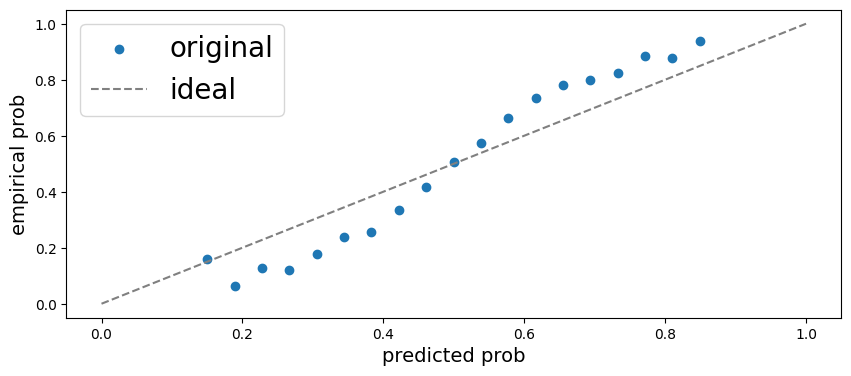

In [93]:
pred_probs_space = np.linspace(y_test_forest.min(), y_test_forest.max(), 20)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_test[(y_test_forest > pred_probs_space[i]) & (y_test_forest < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)


plt.figure(figsize=(10,4))
plt.scatter(pred_probs_midpoints, empirical_probs, marker='o')
# plt.title(f"{model_str}", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')

plt.legend(['original', 'ideal'], fontsize=20)
plt.show()

In [83]:
from sklearn.linear_model import LogisticRegression

In [87]:
lr = LogisticRegression()
lr.fit(y_test_forest.reshape(-1,1), y_test)

LogisticRegression()

In [88]:
from sklearn.metrics import brier_score_loss

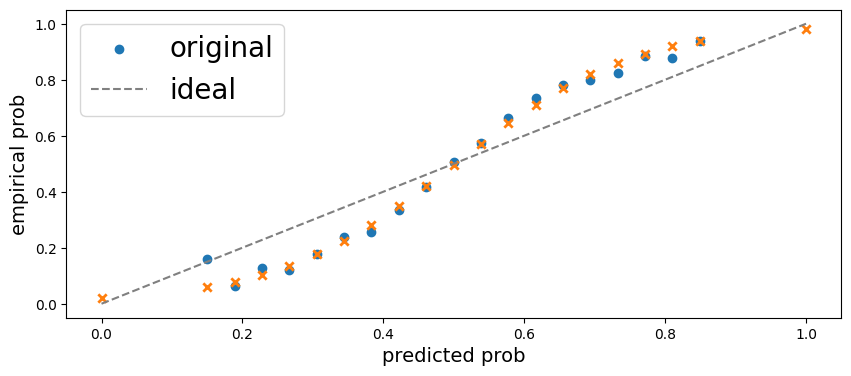

In [96]:
pred_probs_space = np.linspace(y_test_forest.min(), y_test_forest.max(), 20)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_test[(y_test_forest > pred_probs_space[i]) & (y_test_forest < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)


calibrated_probs = lr.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]

plt.figure(figsize=(10,4))
plt.scatter(pred_probs_midpoints, empirical_probs, marker='o')
# plt.title(f"{model_str}", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.scatter([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='x')

plt.legend(['original', 'ideal'], fontsize=20)
plt.show()